In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from custom_loss import custom_loss_function
# import custom_metric

2024-03-14 11:19:56.061742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 11:19:56.168440: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 11:19:56.172426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 11:19:56.172443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [3]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
import datetime as dt
from tensorflow.keras import models

In [4]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Data creation and clean

In [7]:
# import data and check columns
df = pd.read_csv('../raw_data/final_df.csv')
df.columns

Index(['meeting_id', 'meeting_name', 'date', 'country_code', 'event_number',
       'distance', 'distance_unit', 'distance_furlongs',
       'distance_raw_furlongs', 'race_class',
       ...
       '10 mins', '5 mins', '3 mins', '2 mins', '1 min ', 'Post Time',
       'Last Traded Price', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max'],
      dtype='object', length=140)

In [13]:
#testing pipeline
from pipeline_cleaning import clean_data, transforming_data
df_clean= clean_data(df.copy())
df_transform = transforming_data(df_clean.copy())

drop done
step two
Cleaned the data


In [14]:
pd.DataFrame(df_transform[0]).columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [11]:
train = df_transform[0]
val = df_transform[1]
test = df_transform[2]

In [12]:
X_train = train.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
X_val = val.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
X_test = test.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1 )

KeyError: "['event_number'] not found in axis"

In [11]:
X_train.shape, X_val.shape, X_test.shape

((73401, 66), (56804, 66), (40350, 66))

In [12]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [13]:
y_train = np.array(train[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
y_val = np.array(val[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
y_test = np.array(test[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))

In [14]:
test[['win_or_lose']].replace({'win_or_lose':0.5}, 1.0).value_counts()

win_or_lose
0.0            35788
1.0             4562
dtype: int64

# Model - Custom Loss Softmax

In [15]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.Accuracy(name='accuracy'),
    # keras.metrics.F1Score(name='f1_score')
    # keras.metrics.F1   # precision-recall curve add precsion, F1, accuracy
    
]
#change to mse, mae, rmse

2024-03-14 10:28:32.161964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 10:28:32.163142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 10:28:32.163561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-14 10:28:32.163773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-14 10:28:32.164097: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [16]:
#build model
def inititialize_model_softmax(X_train):

    #architecture
#   normaliser = Normalization() -suggestion to do normalization on target (y)
    model = models.Sequential()
    model.add(layers.Dense(1000, activation = 'relu', input_dim=X_train.shape[-1]))
    model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(500, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(100, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(2, activation = 'softmax'))
    
    # classification comilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss=custom_loss_function,
              optimizer=optimizer, 
              metrics=metrics)
    return model

In [17]:
#initialize model
model_softmax = inititialize_model_softmax(X_train)
model_softmax.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              67000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 69,002
Trainable params: 69,002
Non-trainable params: 0
_________________________________________________________________


In [18]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [19]:
es = EarlyStopping(patience=3, monitor="val_loss")
# Train the model
history = model_softmax.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs=15, #increase number of epochs
                    batch_size=32, 
                    callbacks=[es])

Epoch 1/15
2294/2294 [==============================] - 35s 14ms/step - loss: -0.0700 - recall: 0.8655 - precision: 0.9605 - prc: 0.9362 - accuracy: 0.0000e+00 - val_loss: -0.0790 - val_recall: 0.8638 - val_precision: 0.9614 - val_prc: 0.9424 - val_accuracy: 0.0000e+00
Epoch 2/15
2294/2294 [==============================] - 32s 14ms/step - loss: -0.0794 - recall: 0.8680 - precision: 0.9633 - prc: 0.9401 - accuracy: 0.0000e+00 - val_loss: -0.0798 - val_recall: 0.8638 - val_precision: 0.9615 - val_prc: 0.9395 - val_accuracy: 0.0000e+00
Epoch 3/15
2294/2294 [==============================] - 28s 12ms/step - loss: -0.0798 - recall: 0.8686 - precision: 0.9639 - prc: 0.9402 - accuracy: 0.0000e+00 - val_loss: -0.0801 - val_recall: 0.8644 - val_precision: 0.9621 - val_prc: 0.9394 - val_accuracy: 0.0000e+00
Epoch 4/15
2294/2294 [==============================] - 29s 12ms/step - loss: -0.0801 - recall: 0.8692 - precision: 0.9646 - prc: 0.9402 - accuracy: 0.0000e+00 - val_loss: -0.0807 - val_reca

In [20]:
y_test_pred = model_softmax.predict(X_test, verbose=0)

In [21]:
results_df = pd.DataFrame({'y_pred': y_test_pred.round(2)[:,0], 'y_true': test['win_or_lose'].replace(0.5, 1.0)})
results_df

,y_pred,y_true
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
40345,0.0,0.0
40346,0.0,0.0
40347,1.0,1.0
40348,0.0,0.0


In [22]:
results_df.y_true.value_counts()

0.0    35788
1.0     4562
Name: y_true, dtype: int64

In [23]:
results_df['y_pred_050'] = results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
results_df.y_pred_050.value_counts()

0.0    34330
1.0     6020
Name: y_pred_050, dtype: int64

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
scores = {
    'accuracy': [accuracy_score(results_df.y_true, results_df.y_pred_050)],
    'precision': [precision_score(results_df.y_true, results_df.y_pred_050)],
    'recall': [recall_score(results_df.y_true, results_df.y_pred_050)],
    'f1': [f1_score(results_df.y_true, results_df.y_pred_050)]
}
scores_df = pd.DataFrame(scores)
scores_df

,accuracy,precision,recall,f1
0,0.961933,0.751329,0.991451,0.854848


In [25]:
model_softmax.evaluate(X_test, y_test)

  17/1261 [..............................] - ETA: 7s - loss: -0.1068 - recall: 0.8613 - precision: 0.9706 - prc: 0.9437 - accuracy: 0.0000e+00

1261/1261 [==============================] - 7s 5ms/step - loss: -0.0821 - recall: 0.8651 - precision: 0.9629 - prc: 0.9366 - accuracy: 0.0000e+00


[-0.08208969980478287,
 0.8651139736175537,
 0.9629244208335876,
 0.9365705251693726,
 0.0]

In [26]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.title('Model Accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='best')
    # plt.show()

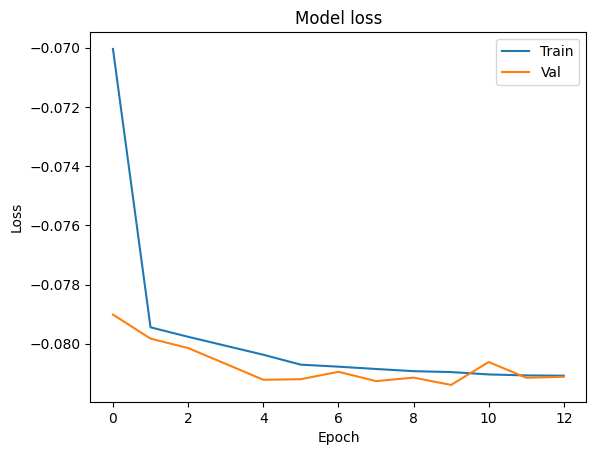

In [27]:
plot_loss_accuracy(history)

In [28]:
sum(results_df.y_pred*test['1_min_'])

60589.91142024527

In [29]:
test_results_df = test.copy()[['meeting_id', 'event_number',
       'place', 
       #'15_mins', '10_mins', '5_mins', '3_mins', '2_mins',
       '1_min_', 'win_or_lose']]

test_results_df['race_id'] = test_results_df['meeting_id'].astype(str) + '_' + test_results_df['event_number'].astype(str)
test_results_df['y_pred'] = results_df['y_pred']
test_results_df['bet'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
test_results_df['bet_075'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.75 else 0.0)
test_results_df['bet_080'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.80 else 0.0)
test_results_df['bet_090'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.90 else 0.0)
test_results_df['bet_095'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.95 else 0.0)
test_results_df['profit_050'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet']
test_results_df['profit_075'] = test_results_df['profit_050']*test_results_df['bet_075']
test_results_df['profit_080'] = test_results_df['profit_050']*test_results_df['bet_080']
test_results_df['profit_090'] = test_results_df['profit_050']*test_results_df['bet_090']
test_results_df['profit_095'] = test_results_df['profit_050']*test_results_df['bet_095']
test_results_df = test_results_df.sort_values(by='race_id')

In [30]:
random_bet = []
for race in sorted(set(test_results_df.race_id)):
    n_runners = test_results_df.race_id.value_counts()[race]
    ls = list(np.zeros(n_runners))
    ls[np.random.randint(0, n_runners)] = 1.0
    random_bet+=ls
random_bet

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [31]:
best_odds_bet = []
for race in sorted(set(test_results_df.race_id)):
    sub_df = test_results_df[test_results_df.race_id==race].reset_index()
    odds_ls = list(sub_df['1_min_'])
    n_runners = len(sub_df)
    ls = list(np.zeros(n_runners))
    ls[odds_ls.index(min(odds_ls))] = 1.0
    best_odds_bet+=ls
best_odds_bet

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0

In [32]:
test_results_df['bet_random'] = random_bet
test_results_df['profit_random'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_random']
test_results_df['bet_best_odds'] = best_odds_bet
test_results_df['profit_best_odds'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_best_odds']

In [33]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [34]:
test_results_df.head(50)

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.70,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
12897,35179.0,7.0,9.0,340.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9587,35179.0,7.0,10.0,20.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
17586,35179.0,7.0,8.0,70.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
27302,35179.0,7.0,13.0,9.60,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
24315,35179.0,7.0,4.0,10.50,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
22589,35179.0,7.0,2.0,4.50,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.00,-1.00,-1.00,-1.00,-1.00,0.0,-0.0,1.0,-1.00
7143,35179.0,7.0,7.0,10.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
8212,35179.0,7.0,5.0,190.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9849,35179.0,7.0,6.0,36.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00


In [35]:
test_results_df[(test_results_df.win_or_lose==0.0)&(test_results_df.bet_080==0.0 )&(test_results_df.bet==1.0 )]

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
38300,35280.0,4.0,2.0,6.20,0.0,35280.0_4.0,0.67,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
4089,35426.0,3.0,2.0,2.06,0.0,35426.0_3.0,0.69,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
32217,35472.0,7.0,3.0,5.30,0.0,35472.0_7.0,0.56,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
32727,35509.0,3.0,4.0,36.00,0.0,35509.0_3.0,0.78,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17807,35579.0,6.0,2.0,3.15,0.0,35579.0_6.0,0.53,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
30836,35670.0,7.0,4.0,4.80,0.0,35670.0_7.0,0.62,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
20853,36239.0,4.0,2.0,6.20,0.0,36239.0_4.0,0.73,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
30826,36291.0,5.0,2.0,2.70,0.0,36291.0_5.0,0.76,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
40203,36390.0,1.0,4.0,8.20,0.0,36390.0_1.0,0.50,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
40285,36496.0,1.0,2.0,4.70,0.0,36496.0_1.0,0.73,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0


In [36]:
test_results_df[test_results_df.race_id=='35179.0_7.0']

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.7,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
12897,35179.0,7.0,9.0,340.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9587,35179.0,7.0,10.0,20.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17586,35179.0,7.0,8.0,70.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
27302,35179.0,7.0,13.0,9.6,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
24315,35179.0,7.0,4.0,10.5,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
22589,35179.0,7.0,2.0,4.5,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-0.0,1.0,-1.0
7143,35179.0,7.0,7.0,10.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
8212,35179.0,7.0,5.0,190.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9849,35179.0,7.0,6.0,36.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0


In [37]:
race_results = test_results_df.groupby(by='race_id', as_index=False).sum()
race_results

,race_id,meeting_id,event_number,place,1_min_,win_or_lose,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
0,35179.0_7.0,492506.0,98.0,105.0,998.30,1.0,2.00,2.0,2.0,2.0,...,2.0,11.00,11.00,11.00,11.00,11.00,1.0,-1.0,1.0,-1.00
1,35180.0_7.0,281440.0,56.0,127.0,239.20,1.0,1.00,1.0,1.0,1.0,...,1.0,0.70,0.70,0.70,0.70,0.70,1.0,-1.0,1.0,0.70
2,35184.0_1.0,316656.0,9.0,45.0,135.64,1.0,1.00,1.0,1.0,1.0,...,1.0,1.84,1.84,1.84,1.84,1.84,1.0,-1.0,1.0,1.84
3,35184.0_2.0,351840.0,20.0,55.0,1181.79,1.0,1.00,1.0,1.0,1.0,...,1.0,0.89,0.89,0.89,0.89,0.89,1.0,-1.0,1.0,0.89
4,35184.0_3.0,387024.0,33.0,66.0,247.80,1.0,1.00,1.0,1.0,1.0,...,1.0,6.60,6.60,6.60,6.60,6.60,1.0,-1.0,1.0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,37729.0_2.0,415019.0,22.0,66.0,2211.81,1.0,2.00,2.0,2.0,2.0,...,2.0,-0.49,-0.49,-0.49,-0.49,-0.49,1.0,-1.0,1.0,0.51
4557,37729.0_3.0,415019.0,33.0,66.0,436.60,1.0,1.00,1.0,1.0,1.0,...,1.0,2.70,2.70,2.70,2.70,2.70,1.0,-1.0,1.0,2.70
4558,37729.0_4.0,301832.0,32.0,36.0,84.80,1.0,1.00,1.0,1.0,1.0,...,1.0,4.50,4.50,4.50,4.50,4.50,1.0,-1.0,1.0,-1.00
4559,37729.0_5.0,339561.0,45.0,45.0,132.35,1.0,1.75,2.0,2.0,2.0,...,0.0,17.50,17.50,17.50,18.50,0.00,1.0,-1.0,1.0,-1.00


In [38]:
race_results.columns

Index(['race_id', 'meeting_id', 'event_number', 'place', '1_min_',
       'win_or_lose', 'y_pred', 'bet', 'bet_075', 'bet_080', 'bet_090',
       'bet_095', 'profit_050', 'profit_075', 'profit_080', 'profit_090',
       'profit_095', 'bet_random', 'profit_random', 'bet_best_odds',
       'profit_best_odds'],
      dtype='object')

In [39]:
profit_trend_df = race_results[['profit_050', 'profit_075', 'profit_080', 'profit_090', 'profit_095', 'profit_random', 'profit_best_odds']].cumsum()
profit_trend_df

,profit_050,profit_075,profit_080,profit_090,profit_095,profit_random,profit_best_odds
0,11.000,11.000,11.000,11.000,11.000,-1.00,-1.00
1,11.700,11.700,11.700,11.700,11.700,-2.00,-0.30
2,13.540,13.540,13.540,13.540,13.540,-3.00,1.54
3,14.430,14.430,14.430,14.430,14.430,-4.00,2.43
4,21.030,21.030,21.030,21.030,21.030,-5.00,1.43
...,...,...,...,...,...,...,...
4556,33029.235,32933.035,32913.035,32724.635,32730.915,-489.64,-52.76
4557,33031.935,32935.735,32915.735,32727.335,32733.615,-490.64,-50.06
4558,33036.435,32940.235,32920.235,32731.835,32738.115,-491.64,-51.06
4559,33053.935,32957.735,32937.735,32750.335,32738.115,-492.64,-52.06


<AxesSubplot:>

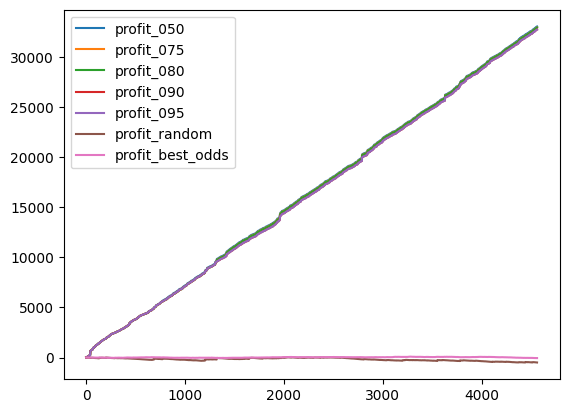

In [40]:
profit_trend_df.plot(kind='line')

<AxesSubplot:xlabel='y_pred', ylabel='Count'>

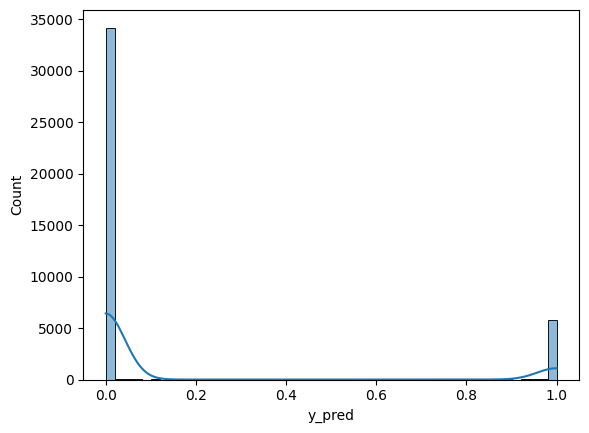

In [41]:
sns.histplot(test_results_df.y_pred, bins= 50, kde =True)